In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1)

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
  mean_absolute_error,
  mean_squared_error,
  mean_absolute_percentage_error,
  accuracy_score,
  f1_score
)

from sklearn.utils import resample

import random

In [18]:
n_classes = 10

X, y = load_digits(n_class=n_classes, return_X_y=True)
to_sample = False

In [19]:
# X, y = sampled[:, :-1], np.array(sampled[:, -1], dtype=np.int32)
X.shape, y.shape, np.unique(y)

((1797, 64), (1797,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

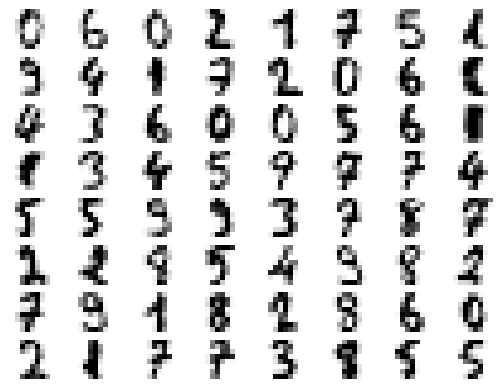

In [20]:
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(X[random.randint(0, X.shape[0])].reshape(8, 8), cmap='Greys')

In [21]:
X.shape, y.shape

((1797, 64), (1797,))

In [22]:
n_features = X.shape[1]
n_targets = n_classes

In [23]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from common.distributor import UniformDataDistributor, DataDistributor
from optimization.federative.fedavg import FederatedAveraging, Simulation
from optimization.federative.scaffold import Scaffold
from optimization.federative.fedprox import FedProx
from optimization.federative.scaffnew import Scaffnew
from optimization.federative.fedfair import FedFair

In [25]:
from function.vanilla import MSERidgeLinear, MSELassoLinear
from function.torch import TorchFunction

In [26]:
import torch

In [27]:
torch_model = torch.nn.Sequential(
  torch.nn.Linear(n_features, 32),
  torch.nn.Sigmoid(),
  torch.nn.Linear(32, n_targets),
  torch.nn.Softmax(dim=-1)
)
function = TorchFunction(torch_model, torch.nn.CrossEntropyLoss())

torch_enable = True

In [28]:
sum([params.numel() for params in torch_model.parameters()])

2410

In [29]:
distributor = DataDistributor(test_size=0.2, server_fraction=0.2)

In [30]:
from pipeline.pipeline import Pipeline

In [31]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



Scaffold for parameters: 
 n_clients=32,  iid_fraction=0.3,  clients_fraction=0.4
 batch_size=256,  epochs=256,  rounds=48
 eta=0.75:


learning: 100%|██████████| 48/48 [00:13<00:00,  3.48it/s]


f1_score : 0.9029239766081871

FedFair for parameters: 
 n_clients=32,  iid_fraction=0.3,  clients_fraction=0.4
 batch_size=256,  epochs=256,  rounds=48
 eta=0.75,  lmbd=0.01:


learning: 100%|██████████| 48/48 [00:09<00:00,  4.92it/s]


f1_score : 0.9149199184028904

Scaffnew for parameters: 
 n_clients=32,  iid_fraction=0.3,  clients_fraction=1
 batch_size=256,  rounds=48,  eta=0.75
 proba=0.00195312:


learning: 100%|██████████| 48/48 [00:20<00:00,  2.29it/s]


f1_score : 0.8870780170122275
done


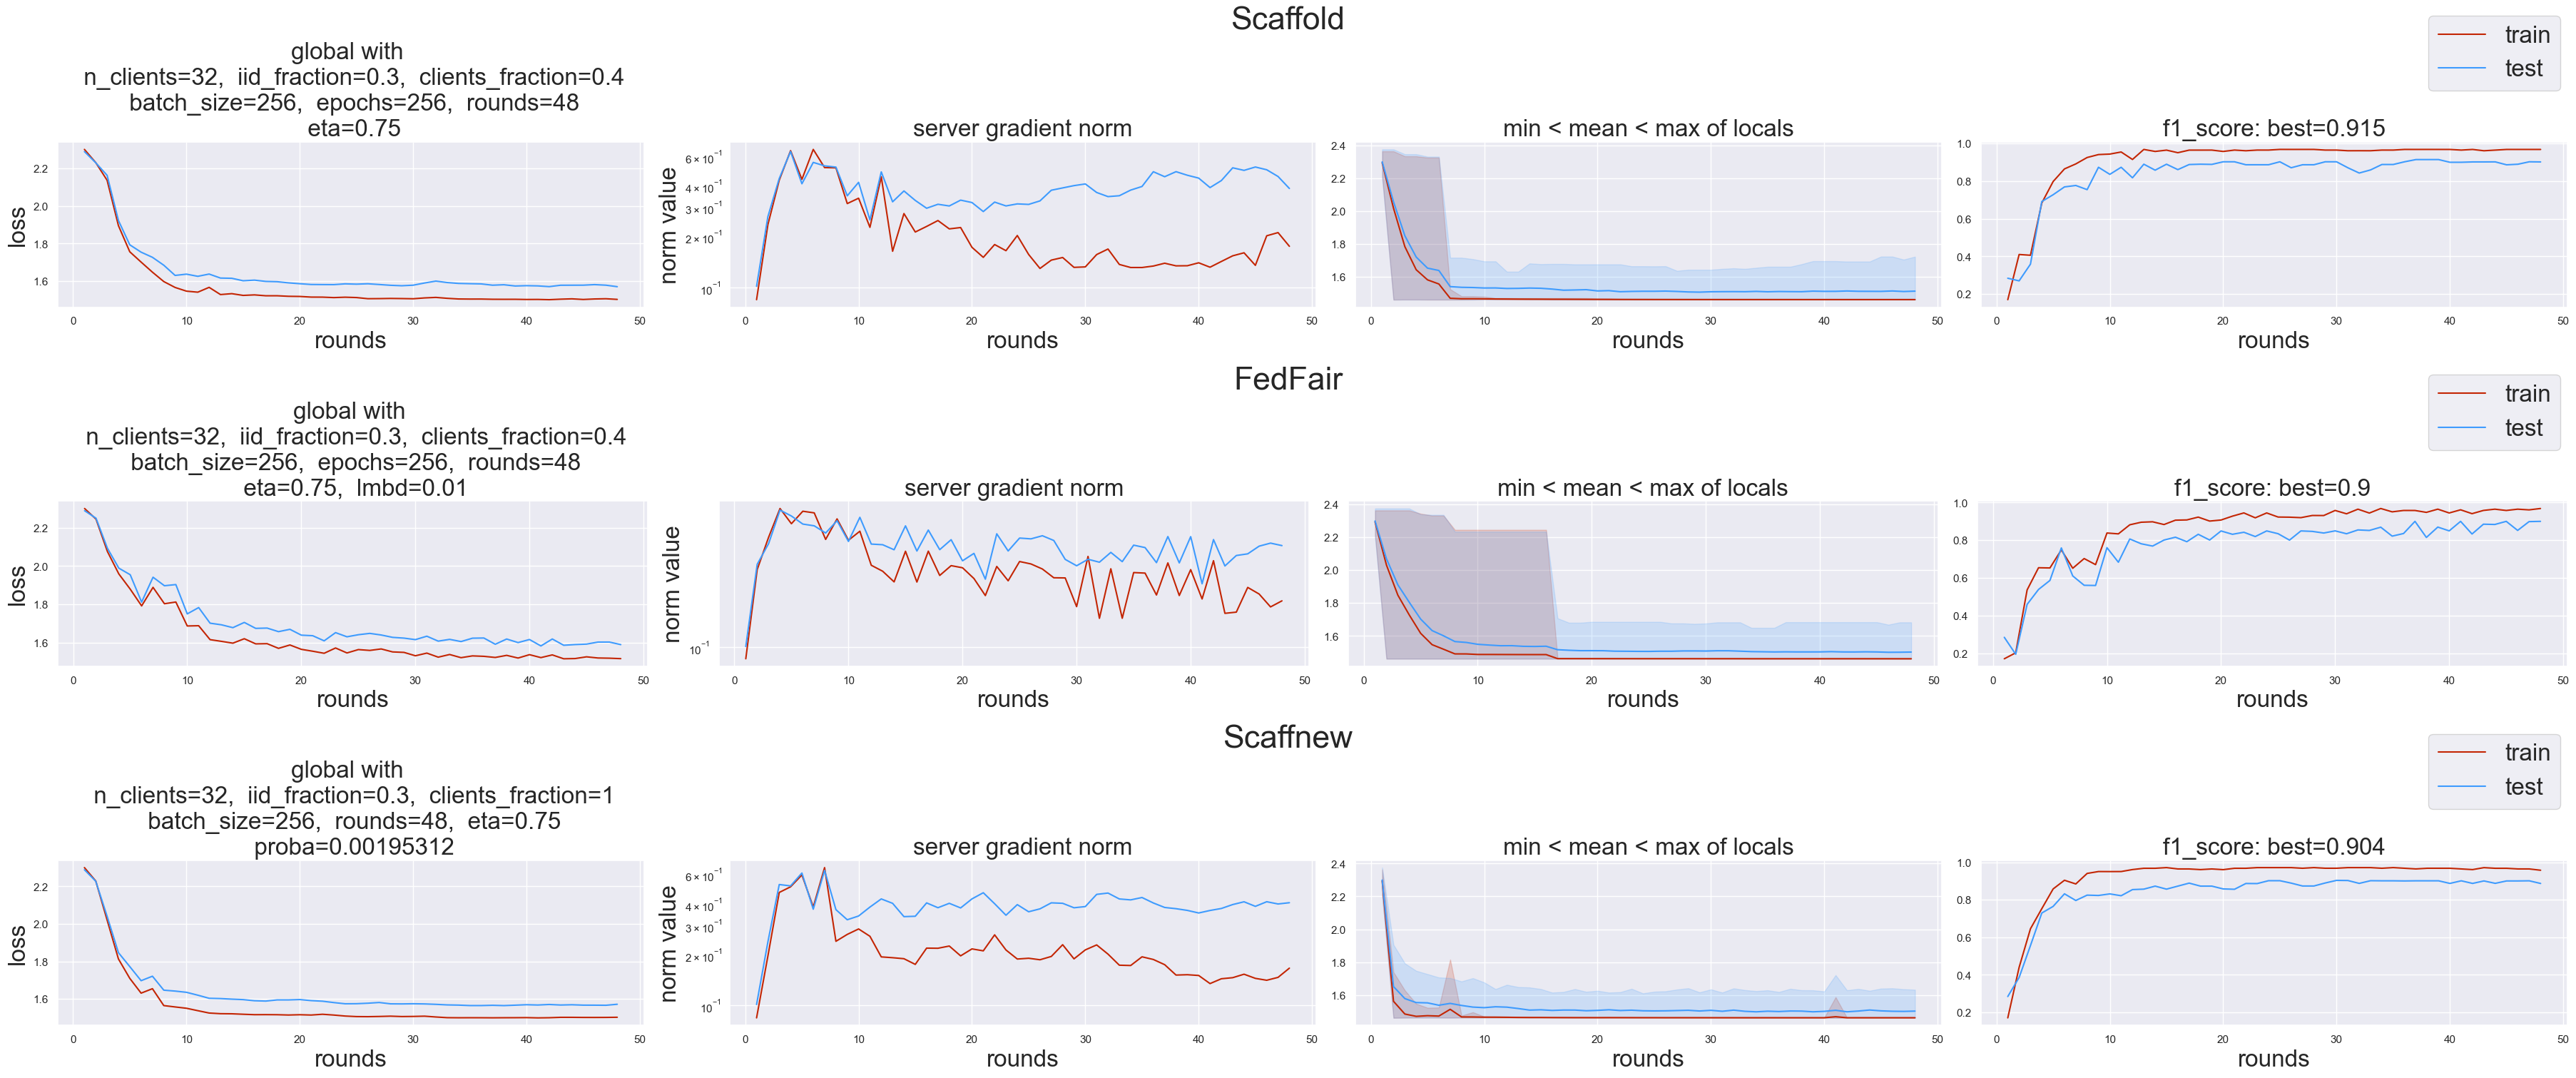

In [32]:
optimizer_parameters = {
  Scaffold : {
    "n_clients" : [32],
    "iid_fraction" : [0.3],
    "clients_fraction": [0.4],
    "batch_size": [256], 
    "epochs": [256], # 16, 64, 
    "rounds": [48],
    "eta": [75e-2], # , 1e-2
  },
  FedFair : {
    "n_clients" : [32],
    "iid_fraction" : [0.3],
    "clients_fraction": [0.4],
    "batch_size": [256], 
    "epochs": [256], # 16, 64, 
    "rounds": [48],
    "eta": [75e-2], # , 1e-2
    "lmbd" : [1e-2]
  },
  Scaffnew : {
    "n_clients" : [32],
    "iid_fraction" : [0.3],
    "clients_fraction": [1], # funny things happens when clients_fraction is not 1
    "batch_size": [256], 
    "rounds": [48],
    "eta": [75e-2], # , 1e-2
    "proba" : [1/512]
  }
}

metrics = {
  "f1_score" : lambda y_proba, y_true: f1_score(np.argmax(y_proba, axis=1), y_true, average="weighted")
}

pipeline = Pipeline(
  function=function,
  metrics=metrics,
  optimizer_parameters=optimizer_parameters,
  distributor=distributor,
  X=X,
  y=y,
)

best, best_params = pipeline.run(
  choose_best_by="accuracy",
  scaled=False,
  with_grads=True,
  reducers=[]
)

print("done")

In [113]:
best_params

{'clients_fraction': 0.3, 'batch_size': 64, 'epochs': 128, 'eta': 0.001}